# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks.tracker import *

In [3]:
PATH = Path('data/IAM_handwriting')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Helpers

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(im.data), alpha=alpha)
    if title: ax.set_title(title)
    return ax

In [6]:
def rshift(tgt, bos_token=1):
    "Shift y to the right by prepending token"
    bos = torch.zeros((tgt.size(0),1), device=device).type_as(tgt) + bos_token
    return torch.cat((bos, tgt[:,:-1]), dim=-1)

def subsequent_mask(size):
    return torch.tril(torch.ones((1,size,size), device=device).byte())

## Loss, Metrics, Callbacks

In [7]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = self.loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)        # necessary for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs
    
    def loss_prep(self, pred, target):
        "equalize input/target sl; combine bs/sl dimensions"
        bs,tsl = target.shape
        _ ,sl,vocab = pred.shape

        # F.pad( front,back for dimensions: 1,0,2 )
        if sl>tsl: target = F.pad(target, (0,sl-tsl))
        if tsl>sl: pred = F.pad(pred, (0,0,0,tsl-sl))

        targ = target.contiguous().view(-1).long()
        pred = pred.contiguous().view(-1, vocab)
        return pred, targ

In [8]:
import Levenshtein as Lev

class CER(Callback):
    def __init__(self, fn):
        super().__init__()
        self.name = 'cer'
        self.fn = fn

    def on_epoch_begin(self, **kwargs):
        self.errors, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        error,size = cer(last_output, last_target, self.fn)
        self.errors += error
        self.total += size
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.errors/self.total)

In [9]:
def cer(preds, targs, fn):
    bs = targs.size(0)
    res = torch.argmax(preds, dim=-1)
    error = 0
    for i in range(bs):
        p = str(fn(res[i]))
        t = str(fn(targs[i]))
        error += Lev.distance(t, p)/(len(t) or 1)
    return error, bs

In [10]:
class TeacherForce(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

# Data

## word combo

In [ ]:
fname = 'edited_sm_synth.csv'
CSV = PATH/fname
FOLDER = 'edited_sm_synth'

df = pd.read_csv(CSV)
len(df)

In [ ]:
sz,bs = 256,50
seq_len,word_len = 100,50

## font generated

In [ ]:
#font generated
fname = 'font_mix_129k.csv'
FOLDER = 'combo_cat'

In [ ]:
CSV = PATH/fname
df = pd.read_csv(CSV)

sz,bs = 512,15
seq_len,word_len = 750,300
len(df)

## handwriting

In [ ]:
#handwriting only
fname = 'hand_mix_25k.csv'
FOLDER = 'combo_cat'

In [ ]:
CSV = PATH/fname
df = pd.read_csv(CSV)

sz,bs = 512,15
seq_len,word_len = 750,300
len(df)

## paragraphs

In [11]:
fname = 'edited_pg.csv'
FOLDER = 'paragraphs'

In [12]:
CSV = PATH/fname
df = pd.read_csv(CSV)

sz,bs = 512,15
seq_len,word_len = 750,300
len(df)

1524

# ModelData

In [13]:
tfms = get_transforms(do_flip=False, max_zoom=1, max_rotate=2, max_warp=0.1, max_lighting=0.5)

def force_gray(image): return image.convert('L').convert('RGB')

## SentencePiece

In [14]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.Load(str(PATH/'spm_full_10k.model'))
sp.SetEncodeExtraOptions("eos")
sp.SetDecodeExtraOptions("bos:eos")

True

In [15]:
def add_cap_tokens(text):  # before encode
    re_caps = re.compile(r'[A-Z]+')
    return re_caps.sub(_replace_caps, text)
    
def _replace_caps(m):
    tok = '[UP]' if m.end()-m.start() > 1 else '[MAJ]'
    return tok + m.group().lower()

def remove_cap_tokens(text):  # after decode
    text = re.sub(r'\[UP\]\w+', lambda m: m.group()[4:].upper(), text)  #cap entire word
    text = re.sub(r'\[MAJ\]\w?', lambda m: m.group()[5:].upper(), text) #cap first letter
    return text

### Word only (development)

In [28]:
bs=20

In [29]:
def label_collater(samples:BatchSamples, pad_idx:int=0):
    "Function that collect samples and pads ends of labels."
    data = to_data(samples)
    ims, lbls = zip(*data)
    imgs = torch.stack(list(ims))
    if len(data) is 1 and lbls[0] is 0:   #predict
        labels = torch.zeros(1,1).long()
        return imgs, labels    
    max_len = max([len(s) for s in lbls])
    labels = torch.zeros(len(data), max_len+1).long() + pad_idx  # add 1 to max_len to account for bos token
    for i,lbl in enumerate(lbls):
        labels[i,:len(lbl)] = torch.from_numpy(lbl)  #padding end    
    return imgs, labels

In [30]:
class SPMTokenizer(BaseTokenizer):
    def tokenizer(self, t:str) -> List[str]: return sp.EncodeAsIds(t)[1:]

class SPMProcessor(PreProcessor):
    def __init__(self, ds:ItemList=None, chunksize:int=10000):
        self.toknizr = Tokenizer(tok_func=SPMTokenizer, pre_rules=[rm_useless_spaces, add_cap_tokens],
                                 post_rules=[], special_cases=[])
        self.chunksize = chunksize
        
    def process_one(self, item):
        raise Exception("This isn't implemented!  I didn't think it was necessary...")
    
    def process(self, ds):
        tokens = []
        for i in progress_bar(range(0,len(ds),self.chunksize), leave=False):
            tokens += self.toknizr.process_all(ds.items[i:i+self.chunksize])
        ds.items = tokens

class SPMList(ItemList):
    _processor = [SPMProcessor]

    def __init__(self, items:Iterator, sp, **kwargs):
        super().__init__(items, **kwargs)
        self.vocab = sp
        self.pad_idx = 0
        self.copy_new += ['vocab']

    def get(self, i):
        o = super().get(i)
        return Text(o, self.textify(o))

    def reconstruct(self, t:Tensor):
        return Text(t, self.textify(t))
    
    def textify(self, ids):
        if isinstance(ids, torch.Tensor): ids = ids.tolist()
        st = self.vocab.DecodeIds(ids)
        st = remove_cap_tokens(st)
        return st

In [31]:
data = (ImageList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)
        .split_by_rand_pct(valid_pct=0.15, seed=42)
        .label_from_df(label_cls=SPMList, sp=sp)
        .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=label_collater)
       )

In [32]:
# data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(18,10))

### Word only (export)

In [16]:
bs=20

In [17]:
def label_collater(samples:BatchSamples, pad_idx:int=0):
    "Function that collect samples and pads ends of labels."
    data = to_data(samples)
    ims, lbls = zip(*data)
    imgs = torch.stack(list(ims))
    if len(data) is 1 and lbls[0] is 0:   #predict
        labels = torch.zeros(1,1).long()
        return imgs, labels    
    max_len = max([len(s) for s in lbls])
    labels = torch.zeros(len(data), max_len+1).long() + pad_idx  # add 1 to max_len to account for bos token
    for i,lbl in enumerate(lbls):
        labels[i,:len(lbl)] = torch.from_numpy(lbl)  #padding end    
    return imgs, labels

In [18]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.Load(f'{model_prefix}.model')
        self.tok.SetEncodeExtraOptions("eos")

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsIds(t)[1:]
      
class CustomTokenizer():
    def __init__(self, tok_func:Callable, model_prefix:str):
        self.tok_func, self.model_prefix = tok_func,model_prefix
        self.pre_rules = [rm_useless_spaces, add_cap_tokens]
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_one(self, t:str, tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t) 
        return toks 
                                                                         
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`." 
        tok = self.tok_func(self.model_prefix)
        return [self.process_one(t, tok) for t in texts]

In [19]:
class SPList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        model_prefix = self.path/'spm_full_10k'
        cust_tok = CustomTokenizer(SPTokenizer, model_prefix)
        self.processor = TokenizeProcessor(tokenizer=cust_tok, include_bos=False)
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(model_prefix)+'.model')
        self.sp.SetDecodeExtraOptions("bos:eos")
        
        self.pad_idx = 0
        self.copy_new += ['sp']
    
    def get(self, i):
        o = self.items[i]
        return Text(o, self.textify(o))
    
    def reconstruct(self, t:Tensor):
        nonzero_idxs = (t != self.pad_idx).nonzero()
        idx_min = 0
        idx_max = nonzero_idxs.max() if len(nonzero_idxs) > 0 else 0
        return Text(t[idx_min:idx_max+1], self.textify(t[idx_min:idx_max+1]))

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)        
    
    def textify(self, ids):
        if isinstance(ids, torch.Tensor): ids = ids.tolist()
        st = self.sp.DecodeIds(ids)
        st = remove_cap_tokens(st)
        return st

In [20]:
data = (ImageList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)
        .split_by_rand_pct(valid_pct=0.15, seed=42)
        .label_from_df(label_cls=SPList)
        .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=label_collater)
       )

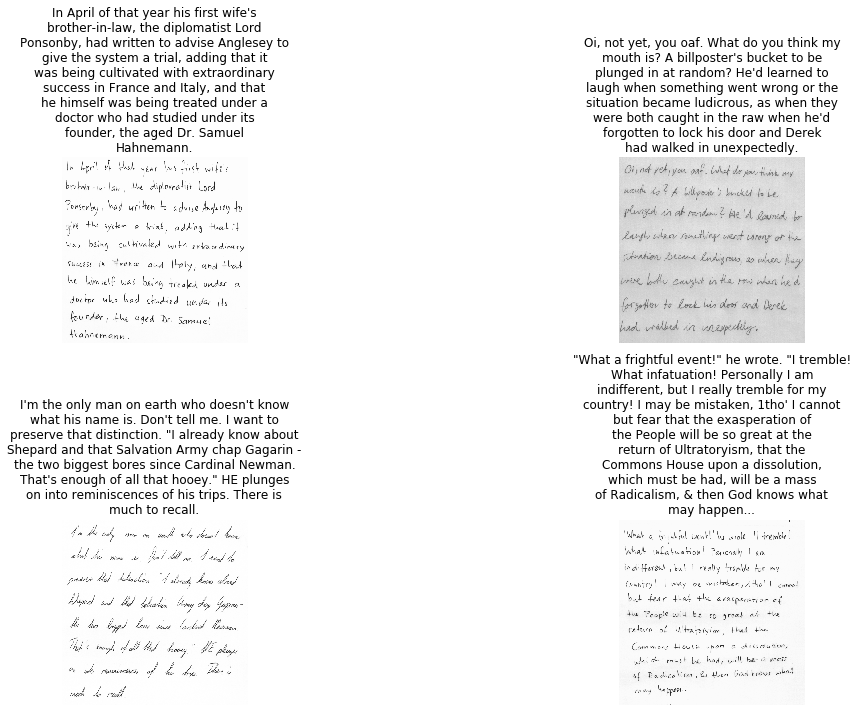

In [21]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(18,10))

### Combo

In [39]:
itos = {}
for i in range(len(sp)):
    itos[i] = sp.id_to_piece(i)

c_itos={}
for k,v in itos.items():
    if k<7:
        c_itos[k] = [k]
    else:
        c_itos[k] = [sp.piece_to_id(c) for c in list(v)]

In [40]:
def characterize(t:Collection[int]) -> Collection[int]:
    return functools.reduce(operator.iconcat, [c_itos[c] for c in t], [])
    # flatten nested list - fastest
    # https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

In [41]:
def multi_label_collater(samples:BatchSamples):
    "Function that collect samples and pads ends of labels."
    data = to_data(samples)
    ims, lbls = zip(*data)
    char_lbls, word_lbls = zip(*lbls)
    imgs = torch.stack(list(ims))
    return imgs, (c_pad(char_lbls), c_pad(word_lbls))
    
def c_pad(lbls, pad_idx=0):
    max_len = max([len(s) for s in lbls])
    labels = torch.zeros(len(lbls), max_len+1).long() + pad_idx  # add 1 to max_len to account for bos token
    for i,lbl in enumerate(lbls):
        labels[i,:len(lbl)] = torch.from_numpy(lbl)  #padding end    
    return labels

In [42]:
class SPMTokenizer(BaseTokenizer):
    def tokenizer(self, t:str) -> List[int]:
        w_toks = sp.EncodeAsIds(t)[1:]
        c_toks = characterize(w_toks)
        return [c_toks, w_toks]

class SPMProcessor(PreProcessor):
    def __init__(self, ds:ItemList=None, chunksize:int=10000):
        self.toknizr = Tokenizer(tok_func=SPMTokenizer, pre_rules=[rm_useless_spaces, add_cap_tokens],
                                 post_rules=[], special_cases=[])
        self.chunksize = chunksize
        
    def process_one(self, item):
        raise Exception("This isn't implemented!  I didn't think it was necessary...")
    
    def process(self, ds):
        tokens = []
        for i in progress_bar(range(0,len(ds),self.chunksize), leave=False):
            tokens += self.toknizr.process_all(ds.items[i:i+self.chunksize])
        ds.items = tokens

In [43]:
class SPMMultiList(ItemList):
    _processor = [SPMProcessor]

    def __init__(self, items:Iterator, sp, **kwargs):
        super().__init__(items, **kwargs)
        self.vocab = sp
        self.pad_idx = 0
        self.copy_new += ['vocab']
    
    def get(self, i):
        c,w = self.items[i]
        return [Text(c, self.textify(c)), Text(w, self.textify(w))]
    
    def reconstruct(self, t:Tensor):
        c,w = t
        return [self.reconstruct_one(c),self.reconstruct_one(w)]

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)
    
    def reconstruct_one(self, x):
        nonzero_idxs = (x != self.pad_idx).nonzero()
        idx_min = 0  #(x != self.pad_idx).nonzero().min()
        idx_max = nonzero_idxs.max() if len(nonzero_idxs) > 0 else 0
        return Text(x[idx_min:idx_max+1], self.textify(x[idx_min:idx_max+1]))
    
    def textify(self, ids):
        if isinstance(ids, torch.Tensor): ids = ids.tolist()
        st = self.vocab.DecodeIds(ids)
        st = remove_cap_tokens(st)
        return st

In [44]:
class ImageMultiList(ImageList):  
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            chars,words = ys[i]
            combined = Text([], str(chars) + '\n\n' + str(words))
            xs[i].show(ax=ax, y=combined, **kwargs)
        plt.tight_layout()

In [45]:
data = (ImageMultiList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)
        .split_by_rand_pct(valid_pct=0.15, seed=42)
        .label_from_df(label_cls=SPMMultiList, sp=sp)
        .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=multi_label_collater)
       )

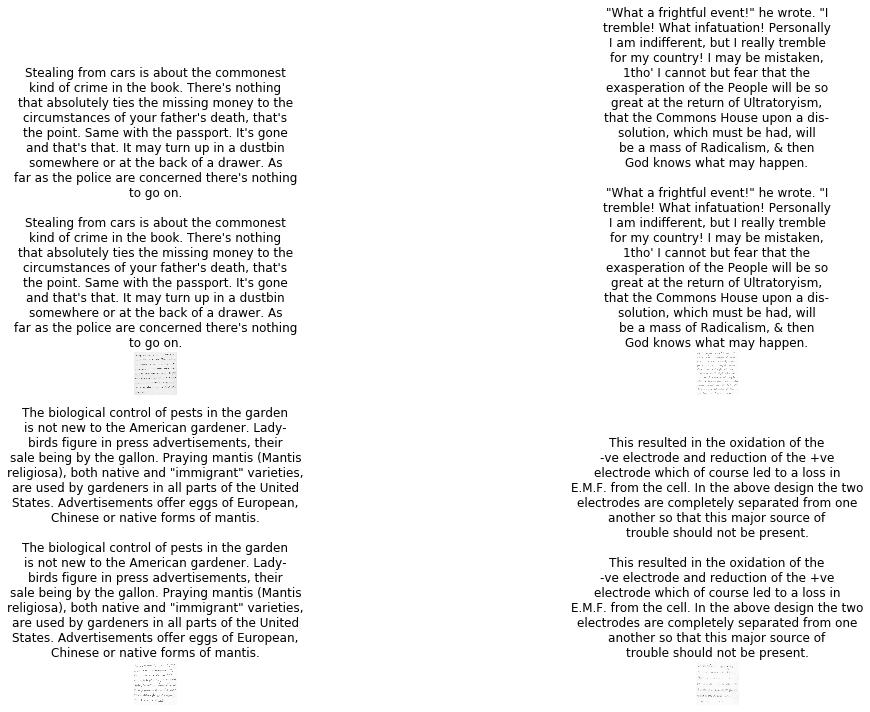

In [47]:
# data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(18,10))

# Transformer Modules

In [72]:
# LayerNorm = nn.LayerNorm
LayerNorm = partial(nn.LayerNorm, eps=1e-4)  # eps: 1e-4 accomodates mixed precision training

In [73]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [74]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

In [75]:
class Encoder(nn.Module):
    __constants__ = ['layers']
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [76]:
class EncoderLayer(nn.Module):
    "Encoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x, mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [77]:
class Decoder(nn.Module):
    __constants__ = ['layers']
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

In [78]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, src, tgt_mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))  # acts as a weak LM
        x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[2](x, self.feed_forward)

In [79]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e4)  #changed from: -1e9 to accomodate mixed precision  
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [80]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return self.linears[-1](x)

In [81]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, h=8, dropout=0.2):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h        # assume d_v always equals d_k
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1,2) for l, x in zip(self.linears, (q, k, v))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [82]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

In [83]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / d_model
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)

        self.register_buffer('pe', pe)    #(1,max_len,d_model)
        # registered buffers are Tensors (not Variables)
        # not a parameter but still want in the state_dict

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [84]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# SentencePiece Architectures

## Word Arch

In [85]:
class LearnedPositionalEmbeddings(nn.Module):
    def __init__(self, d_model, vocab, dropout=0.1):
        super(LearnedPositionalEmbeddings, self).__init__()
        self.nl_tok  = 4
        self.d_model = d_model

        self.embed = nn.Embedding(vocab, d_model, 0)
        self.rows = nn.Embedding(15, d_model//2, 0)
        self.w_cols = nn.Embedding(60, d_model//2, 0)
        
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        rows,cols = self.encode_spatial_positions(x)
        
        row_t = self.rows(rows)            
        col_t = self.w_cols(torch.clamp(cols, max=self.w_cols.num_embeddings-1))  # clamp to max column value
        pos_enc = torch.cat((row_t, col_t), dim=-1)
                
        x = self.embed(x)
        x = (x + pos_enc) * math.sqrt(self.d_model)
        return self.dropout(x)
    
    def encode_spatial_positions(self, x):
        rows,cols = torch.zeros_like(x),torch.zeros_like(x)
        for ii,batch in enumerate(x.unbind()):
            nls = torch.nonzero(batch==self.nl_tok).flatten()
            last = torch.nonzero(batch).flatten()[-1][None]
            splits = torch.cat([nls,last])

            p=0
            for i,n in enumerate(splits, start=1):
                rows[ii,p:n+1] = i
                cols[ii,p:n+1] = torch.arange(1,n-p+2)
                p = n+1
        return rows,cols

In [86]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]

        net = models.resnet18(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)                  #32x32 : 256
        
    def forward(self, x):
        return self.base(x)

In [87]:
class Adaptor(nn.Module):
    def forward(self, x):
        x = x.flatten(2,3).permute(0,2,1)
        return x.mul(8)

In [88]:
class WordTransformer(nn.Module):
    def __init__(self, encoder, decoder, embeddings, generator):
        super(WordTransformer, self).__init__()
        self.encoder = encoder
        self.w_decoder = decoder
        self.embed = embeddings
        self.generator = generator
            
    def forward(self, src, tgt):
        tgt = rshift(tgt, 1).long()
        mask = subsequent_mask(tgt.size(-1))
        return self.w_decoder(self.embed(tgt), self.encoder(src), mask)

    @torch.jit.export
    def generate(self, outs):
        return self.generator(outs)

In [89]:
def make_full_model(vocab, d_model, N=4, drops=0, heads=8):
    c = deepcopy
    attn = MultiHeadedAttention(d_model, heads)
    ff = PositionwiseFeedForward(d_model, drops)
    
    model = WordTransformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops), N),
        LearnedPositionalEmbeddings(d_model, vocab, drops),  #word
        nn.Linear(d_model, vocab),
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [98]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, adaptor, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.adaptor = adaptor
        self.transformer = transformer
        
    def forward(self, src, tgt=None, seq_len=300):
        if tgt is not None:   #train
            feats = self.adaptor(self.img_enc(src))
            outs = self.transformer(feats, tgt)
            return self.transformer.generate(outs)
        else:                 #predict
            self.eval()
            with torch.no_grad():
                feats = self.transformer.encoder(self.adaptor(self.img_enc(src)))
                tgt = torch.ones((src.size(0),1), dtype=torch.long, device=device)

                res = []
                for i in progress_bar(range(seq_len)):
                    emb = self.transformer.embed(tgt)
                    mask = subsequent_mask(tgt.size(-1))
                    dec_outs = self.transformer.w_decoder(emb, feats, mask)
                    prob = self.transformer.generate(dec_outs[:,-1])
                    res.append(prob)
                    pred = torch.argmax(prob, dim=-1, keepdim=True)
                    if (pred==0).all(): break
                    tgt = torch.cat([tgt,pred], dim=-1)
                return torch.stack(res).transpose(1,0).contiguous()

In [99]:
def make_learner(data, d_model, em_sz, N=4, drops=0.1, heads=8, smoothing=0.1):
    img_encoder = ResnetBase(em_sz)
    adaptor = Adaptor()
    transformer = make_full_model(10000, d_model, N, drops, heads)
    net = Img2Seq(img_encoder, adaptor, transformer)
    learn = Learner(data, net, loss_func=LabelSmoothing(smoothing), 
                    metrics=[CER(data.y.reconstruct)], callback_fns=[TeacherForce])  #remove for export
    return learn

In [100]:
learn = make_learner(data, 512, 512, N=4, drops=0.1, heads=8)

In [93]:
# number of trainable parameters
sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
# 50,873,424

50873424

In [101]:
learn.load('word_hw_sp10k'); None

In [95]:
# sd = torch.load(PATH/'models/font_sp10k.pth', map_location=device)
# learn.model.load_state_dict(sd['model'], strict=False)

## Combo Arch

In [ ]:
class LearnedPositionalEmbeddings(nn.Module):
    def __init__(self, d_model, vocab, rows, cols, dropout=0.1):
        super(LearnedPositionalEmbeddings, self).__init__()
        self.nl_tok  = 4
        self.d_model = d_model
        
        self.embed = nn.Embedding(vocab, d_model, 0)
        self.rows = nn.Embedding(15, d_model//2, 0)
        self.c_cols = nn.Embedding(cols[0], d_model//2, 0)
        self.w_cols = nn.Embedding(cols[1], d_model//2, 0)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, char, word):
        return self.encode_one(char, 'char'), self.encode_one(word, 'word')
    
    def encode_one(self, x, kind):
        rows,cols = self.encode_spatial_positions(x)
        
        x_cols = self.c_cols if kind=='char' else self.w_cols

        row_t = self.rows(rows)            
        col_t = x_cols(torch.clamp(cols, max=x_cols.num_embeddings-1))  # clamp to max column value
        pos_enc = torch.cat((row_t, col_t), dim=-1)
                
        x = self.embed(x)
        x = (x + pos_enc) * math.sqrt(self.d_model)
        return self.dropout(x)
    
    def encode_spatial_positions(self, x):
        rows,cols = torch.zeros_like(x),torch.zeros_like(x)
        for ii,batch in enumerate(x.unbind()):
            nls = torch.nonzero(batch==self.nl_tok).flatten()
            last = torch.nonzero(batch).flatten()[-1][None]
            splits = torch.cat([nls,last])

            p=0
            for i,n in enumerate(splits, start=1):
                rows[ii,p:n+1] = i
                cols[ii,p:n+1] = torch.arange(1,n-p+2)
                p = n+1
        return rows,cols

In [ ]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]

        net = models.resnet18(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)                  #32x32 : 256
        
    def forward(self, x):
        return self.base(x)

In [ ]:
class Adaptor(nn.Module):
    def forward(self, x):
        x = x.flatten(2,3).permute(0,2,1)
        return x.mul(8)

In [ ]:
class WordCharTransformer(nn.Module):
    def __init__(self, encoder, c_dec, w_dec, embeddings, generator):
        super(WordCharTransformer, self).__init__()
        self.encoder = encoder
        self.c_decoder = c_dec
        self.w_decoder = w_dec
        self.embed = embeddings
        self.generator = generator
    
    def forward(self, src, mix_tgt):
        c_tgt,w_tgt,c_mask,w_mask = self.shift_with_masks(mix_tgt)
        c_emb,w_emb = self.embed(c_tgt, w_tgt)
        feats = self.encoder(src)
        char_outs = self.c_decoder(c_emb, feats, c_mask)
        word_outs = self.w_decoder(w_emb, feats, w_mask)
        return char_outs, word_outs
        
    def generate(self, c_outs, w_outs):
        return self.generator(c_outs), self.generator(w_outs)
        
    def shift_with_masks(self, mix_tgt):
        c_tgt,w_tgt = mix_tgt
        c_tgt = rshift(c_tgt, 1).long()
        w_tgt = rshift(w_tgt, 1).long()
        
#         c_mask = parallelogram_mask(c_tgt.size(-1), 20)   # char needs word context
#         w_mask = parallelogram_mask(w_tgt.size(-1), 20)   # word needs sentence context
        c_mask = subsequent_mask(c_tgt.size(-1)) 
        w_mask = subsequent_mask(w_tgt.size(-1)) 
        return c_tgt,w_tgt,c_mask,w_mask

In [ ]:
def make_full_model(vocab, d_model, N=4, drops=0, heads=8):
    c = deepcopy
    attn = MultiHeadedAttention(d_model, heads)
    ff = PositionwiseFeedForward(d_model, drops)
    
    model = WordCharTransformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops), N),
        LearnedPositionalEmbeddings(d_model, vocab, rows=15, cols=[100,60]),
        nn.Linear(d_model, vocab),
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [ ]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, adaptor, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.adaptor = adaptor
        self.transformer = transformer
        
    def forward(self, src, tgt):
        feats = self.adaptor(self.img_enc(src))
        char_outs, word_outs = self.transformer(feats, tgt)
        return self.transformer.generate(char_outs, word_outs)

In [ ]:
class MultiCER(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learn):
        super().__init__(learn)
        self.recon = learn.data.y.reconstruct_one

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['char', 'word'])
            
    def on_batch_end(self, last_output, last_target, **kwargs):
        c_out, w_out = last_output
        c_targ, w_targ = last_target
        c_error,size = cer(c_out, c_targ, self.recon)
        w_error,_    = cer(w_out, w_targ, self.recon)
        self.c_errors += c_error
        self.w_errors += w_error
        self.total += size
        
    def on_epoch_begin(self, **kwargs):
        self.c_errors, self.w_errors, self.total = 0, 0, 0

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, [self.c_errors/self.total, self.w_errors/self.total])

In [ ]:
class MultiLabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(MultiLabelSmoothing, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, pred, c_targ, w_targ):
        loss = LabelSmoothing(self.smoothing)
        cl = loss(pred[0], c_targ)
        wl = loss(pred[1], w_targ)
        #print(f'char loss: {cl}  word_loss: {wl}')
        return cl + wl

In [ ]:
def make_learner(data, d_model, em_sz, N=4, drops=0.1, heads=8, smoothing=0.1):
    img_encoder = ResnetBase(em_sz)
    adaptor = Adaptor()
    transformer = make_full_model(len(data.vocab), d_model, N, drops, heads)
    net = Img2Seq(img_encoder, adaptor, transformer)
    learn = Learner(data, net, loss_func=MultiLabelSmoothing(smoothing),
                    callback_fns=[TeacherForce, MultiCER])
    return learn

In [ ]:
learn = make_learner(data, 512, 512, N=4, drops=0.1, heads=8)

In [ ]:
# number of trainable parameters
sum(p.numel() for p in learn.model.parameters() if p.requires_grad)

# Train

In [ ]:
learn.load('word_hw_sp10k'); None

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lrs = 1e-4

In [ ]:
learn.fit_one_cycle(3, max_lr=lrs, callbacks=[SaveModelCallback(learn, name='word_hw_sp10k')])

# arch: (512, 512, N=4, drops=0.1, heads=8); subsequent_masks; lpe
# sentence_piece10k

# data: small dataset, sz:256, bs:50

# combo, 67.7M, 5cycle(1e-3)   
# 10.024531	10.917119	0.059539	0.100420	08:22
# chars:    1.71376   .10433
# words:    1.56690   .06228


# data: font generated, sz:512, bs:15

# combo, 67.7M, 3cycle(1e-3)
# 31.972498	28.244387	0.017639	0.037072	1:45:40   'font_sp10k'
# chars:    32.2701   .01937
# words:    41.7109   .02917


# data: handwriting, sz:512, bs:15

# combo, 67.7M, 5cycle(1e-3)
# 14.077939	11.943507	0.006205	0.003816	21:38   'hw_sp10k'
# chars:    50.1363   .00435
# words:    5.17031   .00043
# test pg:
# chars:    144.698   .03923
# words:    80.1309   .04630
# test upload:
# chars:    129.044   .26124
# words:    61.2923   .30572


# combo, 2cycle(1e-4), preload hw_sp10k
# 12.602509	11.120279	0.005010	0.002936	20:04    'hw_sp10k5'
# test pg:
# chars:    152.536   .03506
# words:    86.5458   .04597
# test upload:
# chars:    131.504   .35796
# words:    59.7730   .27973

# word only, 3cycle(1e-4), preload hw_sp10k
# 6.081270	6.041916	0.000911	14:51    'word_hw_sp10k' ****
#     pg:    82.7050   .04591
#     pg:    83.1463   .04556  no mask
# upload:    64.2214   .31966
# upload:    61.1524   .30548  no mask

# View Model Telemetry

In [ ]:
class FullStats(HookCallback):
    def on_train_begin(self, **kwargs):
        self.modules = [m for m in flatten_model(self.learn.model) if hasattr(m, 'weight')]
        self.g_hooks = Hooks(self.modules, self.g_hook, is_forward=False)
        self.a_hooks = Hooks(self.modules, self.a_hook)
        self.grads,self.acts = [],[]

    def g_hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        oo = next(o)
        return oo.mean().item(),oo.std().item()
    
    def a_hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        return o.mean().item(),o.std().item()

    def on_batch_end(self, train, **kwargs):
        if train:
            self.acts.append(self.a_hooks.stored)
            self.grads.append(self.g_hooks.stored)
            
    def on_train_end(self, **kwargs):
        self.a_hooks.remove()
        self.g_hooks.remove()
        self.acts = tensor(self.acts).permute(2,1,0)
        self.grads = tensor(self.grads).permute(2,1,0)

In [ ]:
learn.fit(1, 1e-5, callbacks=[FullStats(learn)])#, StopAfterNBatches(n_batches=2)])

In [ ]:
acts,grads = learn.full_stats.acts, learn.full_stats.grads
acts.shape,grads.shape

In [ ]:
names=[]
for name, param in learn.model.named_parameters():
    if name.endswith('weight'):
        names.append(name)

names.insert(193, 'transformer.w_embed.embed.weight')
names.insert(194, 'transformer.w_embed.rows.weight')
len(names)

In [ ]:
# :64     img_enc
# 64:67   adaptor
# 67:84   encoder
# 84:137  c_decoder
# 137:190 w_decoder
# 190:    embeddings/generator

plt.figure(figsize=(20,10))
for l in acts[1,137:190]:
    plt.plot(l)
plt.legend(names[137:190])

In [ ]:
avg_act_stds_by_layer = acts[1,:].mean(-1)
avg_grad_stds_by_layer = grads[1,:].mean(-1)

In [ ]:
plt.plot(avg_act_stds_by_layer)

In [ ]:
plt.plot(avg_grad_stds_by_layer)

In [ ]:
for (i,mod),a,g in zip(enumerate(names), avg_act_stds_by_layer, avg_grad_stds_by_layer):
    mod_name = str(mod).split('(')[0]
    print(f"{str(i).ljust(3)} {mod_name.ljust(60)} \
            {str(round(a.item(),5)).ljust(6)} {str(round(g.item(),5)).ljust(6)}")

In [ ]:
# Last batch activations by layer

for (i,mod),m,s in zip(enumerate(names), acts[0,:,-1], acts[1,:,-1]):
    mod_name = str(mod).split('(')[0]
    print(f"{str(i).ljust(3)} {mod_name.ljust(50)} \
            {str(round(m.item(),5)).ljust(6)}  {str(round(s.item(),5)).ljust(6)}")

# Char/Word Greedy results

In [ ]:
def greedy_decode(src, model, seq_len, kind='char', bos_tok=1):
    model.eval()
    tfmr = model.transformer
    img_enc = model.img_enc
    adaptor = model.adaptor
    decoder = tfmr.c_decoder if kind=='char' else tfmr.w_decoder
    
    with torch.no_grad():
        feats = tfmr.encoder(adaptor(img_enc(src)))
        bs = src.size(0)
        tgt = torch.zeros((bs,1), dtype=torch.long, device=device) + bos_tok

        res = []
        for i in progress_bar(range(seq_len)):
            mask = subsequent_mask(tgt.size(-1))
            emb = tfmr.embed.encode_one(tgt, kind)
#             emb = tfmr.embed(tgt)
            
            dec_outs = decoder(emb, feats, mask)
            prob = tfmr.generator(dec_outs[:,-1])
            res.append(prob)
            pred = torch.argmax(prob, dim=-1, keepdim=True)
            if (pred==0).all(): break
            tgt = torch.cat([tgt,pred], dim=-1)
        out = torch.stack(res).transpose(1,0).contiguous()
        return out

In [ ]:
vdl = iter(learn.data.valid_dl)

In [ ]:
x,y = next(vdl)

### Single Word

In [ ]:
# g_preds = greedy_decode(x, learn.model, word_len, 'word', 1)
g_preds = learn.model(x)
g_res = torch.argmax(g_preds, dim=-1)
g = [learn.loss_func(g_preds, y).item()/bs, cer(g_preds, y, data.y.reconstruct)[0]/bs]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[1:7]}')

In [ ]:
#greedy
fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.4}, figsize=(18, 20))
for i,ax in enumerate(axes.flat):
    #i += 8
    p = data.y.reconstruct(g_res[i])
    ax=show_img(x[i], ax=ax, title=p)

### Single Char

In [ ]:
g_preds = greedy_decode(x, learn.model, seq_len, 'char')
g_res = torch.argmax(g_preds, dim=-1)
g = [learn.loss_func(g_preds, y).item()/bs, cer(g_preds, y, data.y.reconstruct)[0]/bs]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[1:7]}')

In [ ]:
#greedy
fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.4}, figsize=(18, 20))
for i,ax in enumerate(axes.flat):
    p = data.y.reconstruct(g_res[i])
    ax=show_img(x[i], ax=ax, title=p)

### Combo Chars

In [ ]:
g_preds = greedy_decode(x, learn.model, seq_len, 'char', 1)
g_res = torch.argmax(g_preds, dim=-1)
loss_func = LabelSmoothing()
g = [loss_func(g_preds, y[0]).item()/bs, cer(g_preds, y[0], data.y.reconstruct_one)[0]/bs]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[1:7]}')

In [ ]:
#greedy
fig, axes = plt.subplots(3,2, gridspec_kw={'hspace': 0.4}, figsize=(18, 20))
for i,ax in enumerate(axes.flat):
    p = data.y.reconstruct_one(g_res[i])
    ax=show_img(x[i], ax=ax, title=p)

### Combo Words

In [ ]:
g_preds = greedy_decode(x, learn.model, word_len, 'word', 1, lm=False)
g_res = torch.argmax(g_preds, dim=-1)
loss_func = LabelSmoothing()
g = [loss_func(g_preds, y[1]).item()/bs, cer(g_preds, y[1], data.y.reconstruct_one)[0]/bs]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[1:7]}')

In [ ]:
#greedy
fig, axes = plt.subplots(3,2, gridspec_kw={'hspace': 0.4}, figsize=(18, 20))
for i,ax in enumerate(axes.flat):
    p = data.y.reconstruct_one(g_res[i])
    ax=show_img(x[i], ax=ax, title=p)

# Test Datasets

In [ ]:
FOLDER = 'uploads'
df = pd.read_csv(PATH/'uploads.csv')
len(df)

sz,bs = 512,14
seq_len = 700

In [ ]:
FOLDER = 'paragraphs'
df = pd.read_csv(PATH/'test_pg.csv')
len(df)

sz,bs = 512,15
seq_len = 700

In [ ]:
# sentencepiece combo
test_data = (ImageMultiList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)
        .split_none()
        .label_from_df(label_cls=SPMMultiList, sp=sp)
        .transform([], size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=multi_label_collater)
       )

In [ ]:
# sentencepiece word
test_data = (ImageList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)
        .split_none()
        .label_from_df(label_cls=SPList)
        .transform([], size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=label_collater)
       )

In [ ]:
x,y = next(iter(test_data.train_dl))

# Quantization

In [ ]:
torch.backends.quantized.engine

In [ ]:
learn.model.img_enc

In [ ]:
modules_to_fuse = [
    ['base.0', 'base.1'],
    ['base.4.0.conv1','base.4.0.bn1'],['base.4.0.conv2','base.4.0.bn2'],
    ['base.4.1.conv1','base.4.1.bn1'],['base.4.1.conv2','base.4.1.bn2'],
    ['base.5.0.conv1','base.5.0.bn1'],['base.5.0.conv2','base.5.0.bn2'],['base.5.0.downsample.0','base.5.0.downsample.1'],
    ['base.5.1.conv1','base.5.1.bn1'],['base.5.1.conv2','base.5.1.bn2'],
    ['base.6.0.conv1','base.6.0.bn1'],['base.6.0.conv2','base.6.0.bn2'],['base.6.0.downsample.0','base.6.0.downsample.1'],
    ['base.6.1.conv1','base.6.1.bn1'],['base.6.1.conv2','base.6.1.bn2'],
    ['base.7.0.conv1','base.7.0.bn1'],['base.7.0.conv2','base.7.0.bn2'],['base.7.0.downsample.0','base.7.0.downsample.1'],
    ['base.7.1.conv1','base.7.1.bn1'],['base.7.1.conv2','base.7.1.bn2'],
]

In [ ]:
f_img_enc = torch.quantization.fuse_modules(learn.model.img_enc, modules_to_fuse)

In [ ]:
f_img_enc

In [ ]:
f_img_enc.fuse_model()

In [ ]:
torch.quantization.convert(f_img_enc, inplace=True)

In [104]:
quantized_model = torch.quantization.quantize_dynamic(
    learn.model, {torch.nn.Linear}, dtype=torch.qint8
)
print(quantized_model)

Img2Seq(
  (img_enc): ResnetBase(
    (base): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
print('Size (MB):', os.path.getsize(PATH/"export.pkl")/1e6)

In [ ]:
print('Size (MB):', os.path.getsize(PATH/'spm_full_10k.model')/1e6)

In [52]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [109]:
print_size_of_model(learn.model)

Size (MB): 100.192115


In [105]:
print_size_of_model(quantized_model)

Size (MB): 100.192115


In [106]:
learn.model = quantized_model

# Convert to Graph (JIT)

## Adjust modules for TorchScript

In [40]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, h=8, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h        # assume d_v always equals d_k
        self.h = h

        self.linear0 = nn.Linear(d_model, d_model)
        self.linear1 = nn.Linear(d_model, d_model)
        self.linear2 = nn.Linear(d_model, d_model)
        self.linear3 = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask:Optional[torch.Tensor]=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        q = self.linear0(q).view(bs, -1, self.h, self.d_k).transpose(1,2)
        k = self.linear1(k).view(bs, -1, self.h, self.d_k).transpose(1,2)
        v = self.linear2(v).view(bs, -1, self.h, self.d_k).transpose(1,2)
        
        # 2) Apply attention on all the projected vectors in batch. 
        x = self.attention(q, k, v, mask=mask)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linear3(x)
    
    def attention(self, query, key, value, mask:Optional[torch.Tensor]=None):
        depth = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)  #changed from: -1e9 to accomodate mixed precision  
        p_attn = F.softmax(scores, dim=-1)
        return torch.matmul(self.dropout(p_attn), value)

In [41]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        
        self.norm0 = LayerNorm(size)
        self.dropout0 = nn.Dropout(dropout)
        self.norm1 = LayerNorm(size)
        self.dropout1 = nn.Dropout(dropout)
        
    def forward(self, x):
        y = self.norm0(x)
        x = x + self.dropout0(self.self_attn(y,y,y))
        
        y = self.norm1(x)
        x = x + self.dropout1(self.feed_forward(y))
        return x

In [42]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        
        self.norm0 = LayerNorm(size)
        self.dropout0 = nn.Dropout(dropout)
        self.norm1 = LayerNorm(size)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = LayerNorm(size)
        self.dropout2 = nn.Dropout(dropout)
         
    def forward(self, x, src, mask):
        y = self.norm0(x)
        x = x + self.dropout0(self.self_attn(y,y,y,mask))
        
        y = self.norm1(x)
        x = x + self.dropout1(self.src_attn(y,src,src))
        
        y = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(y))
        return x

In [43]:
# remove explicit calls to device for scripting (inference on CPU only)

def rshift(tgt, bos_token:int=1):
    "Shift y to the right by prepending token"
    bos = torch.zeros((tgt.size(0),1)).type_as(tgt) + bos_token
    return torch.cat((bos, tgt[:,:-1]), dim=-1)

def subsequent_mask(size:int):
    return torch.tril(torch.ones((1,size,size)).byte())

In [44]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, adaptor, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.adaptor = adaptor
        self.transformer = transformer
        
    def forward(self, src, seq_len:int=300):
        feats = self.transformer.encoder(self.adaptor(self.img_enc(src)))
        tgt = torch.ones((src.size(0),1), dtype=torch.long)

        res = []
        for i in range(seq_len):
            emb = self.transformer.embed(tgt)
            mask = subsequent_mask(tgt.size(-1))
            dec_outs = self.transformer.w_decoder(emb, feats, mask)
            prob = self.transformer.generate(dec_outs[:,-1])
            res.append(prob)
            pred = torch.argmax(prob, dim=-1, keepdim=True)
            if (pred==0).all(): break
            tgt = torch.cat([tgt,pred], dim=-1)
        return torch.stack(res).transpose(1,0).contiguous()

In [45]:
def make_model(vocab_len, d_model, em_sz, N=4, drops=0.1, heads=8):
    img_encoder = ResnetBase(em_sz)
    adaptor = Adaptor()
    transformer = make_full_model(vocab_len, d_model, N, drops, heads)
    return Img2Seq(img_encoder, adaptor, transformer)

In [46]:
model = make_model(10000, 512, 512, N=4, drops=0.1, heads=8)

## Load modified state_dict into model

In [47]:
sd = torch.load(PATH/'models/word_hw_sp10k.pth', map_location=device)

In [123]:
# compare names of saved sd parameters
list(sd['model'].keys())

['img_enc.base.0.weight',
 'img_enc.base.1.weight',
 'img_enc.base.1.bias',
 'img_enc.base.1.running_mean',
 'img_enc.base.1.running_var',
 'img_enc.base.1.num_batches_tracked',
 'img_enc.base.4.0.conv1.weight',
 'img_enc.base.4.0.bn1.weight',
 'img_enc.base.4.0.bn1.bias',
 'img_enc.base.4.0.bn1.running_mean',
 'img_enc.base.4.0.bn1.running_var',
 'img_enc.base.4.0.bn1.num_batches_tracked',
 'img_enc.base.4.0.conv2.weight',
 'img_enc.base.4.0.bn2.weight',
 'img_enc.base.4.0.bn2.bias',
 'img_enc.base.4.0.bn2.running_mean',
 'img_enc.base.4.0.bn2.running_var',
 'img_enc.base.4.0.bn2.num_batches_tracked',
 'img_enc.base.4.1.conv1.weight',
 'img_enc.base.4.1.bn1.weight',
 'img_enc.base.4.1.bn1.bias',
 'img_enc.base.4.1.bn1.running_mean',
 'img_enc.base.4.1.bn1.running_var',
 'img_enc.base.4.1.bn1.num_batches_tracked',
 'img_enc.base.4.1.conv2.weight',
 'img_enc.base.4.1.bn2.weight',
 'img_enc.base.4.1.bn2.bias',
 'img_enc.base.4.1.bn2.running_mean',
 'img_enc.base.4.1.bn2.running_var',
 'i

In [205]:
# compare names of model parameters
names = []
for name,weight in learn.model.named_parameters():
    names.append(name)

names

In [48]:
from collections import OrderedDict
new_sd = OrderedDict()
lin_pattern = re.compile("(linears\.\d)")
sub_pattern = re.compile("(sublayer\.\d\.norm)")

for k,v in sd['model'].items():
    if 'linears' in k:
        fix_k = lin_pattern.sub(lambda x: f'linear{x.group(0)[-1]}', k)
        new_sd[fix_k] = v
    elif 'sublayer' in k:
        fix_k = sub_pattern.sub(lambda x: f'norm{x.group(0)[-6]}', k)
        new_sd[fix_k] = v
    else:
        new_sd[k] = v

In [49]:
model.load_state_dict(new_sd)

<All keys matched successfully>

## convert model to graph; load in learner object

In [67]:
model_trace = torch.jit.script(quantized_model)

In [68]:
print(model_trace.graph)

graph(%self : __torch__.___torch_mangle_121.Img2Seq,
      %src.1 : Tensor,
      %seq_len.1 : int):
  %37 : Function = prim::Constant[name="subsequent_mask"]()
  %35 : int = prim::Constant[value=-1]() # <ipython-input-44-e4c393e5a894>:15:44
  %108 : int = prim::Constant[value=9223372036854775807]()
  %19 : None = prim::Constant()
  %16 : int = prim::Constant[value=4]() # <ipython-input-44-e4c393e5a894>:10:48
  %12 : int = prim::Constant[value=0]() # <ipython-input-44-e4c393e5a894>:10:35
  %14 : int = prim::Constant[value=1]() # <ipython-input-44-e4c393e5a894>:10:38
  %88 : bool = prim::Constant[value=0]()
  %87 : bool = prim::Constant[value=1]()
  %90 : Tensor = prim::Uninitialized()
  %89 : bool = prim::Uninitialized()
  %3 : __torch__.___torch_mangle_120.WordTransformer = prim::GetAttr[name="transformer"](%self)
  %4 : __torch__.___torch_mangle_116.Encoder = prim::GetAttr[name="encoder"](%3)
  %5 : __torch__.Adaptor = prim::GetAttr[name="adaptor"](%self)
  %6 : __torch__.___torch_ma

In [69]:
learn = Learner(data, model_trace)

# Export Learner

In [ ]:
learn.export()

In [ ]:
from tfmr_extensions import *

In [292]:
learn = load_learner(PATH)

/Users/adamschiller/anaconda3/envs/pytorch_1.4/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/adamschiller/anaconda3/envs/pytorch_1.4/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/adamschiller/anaconda3/envs/pytorch_1.4/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.contai

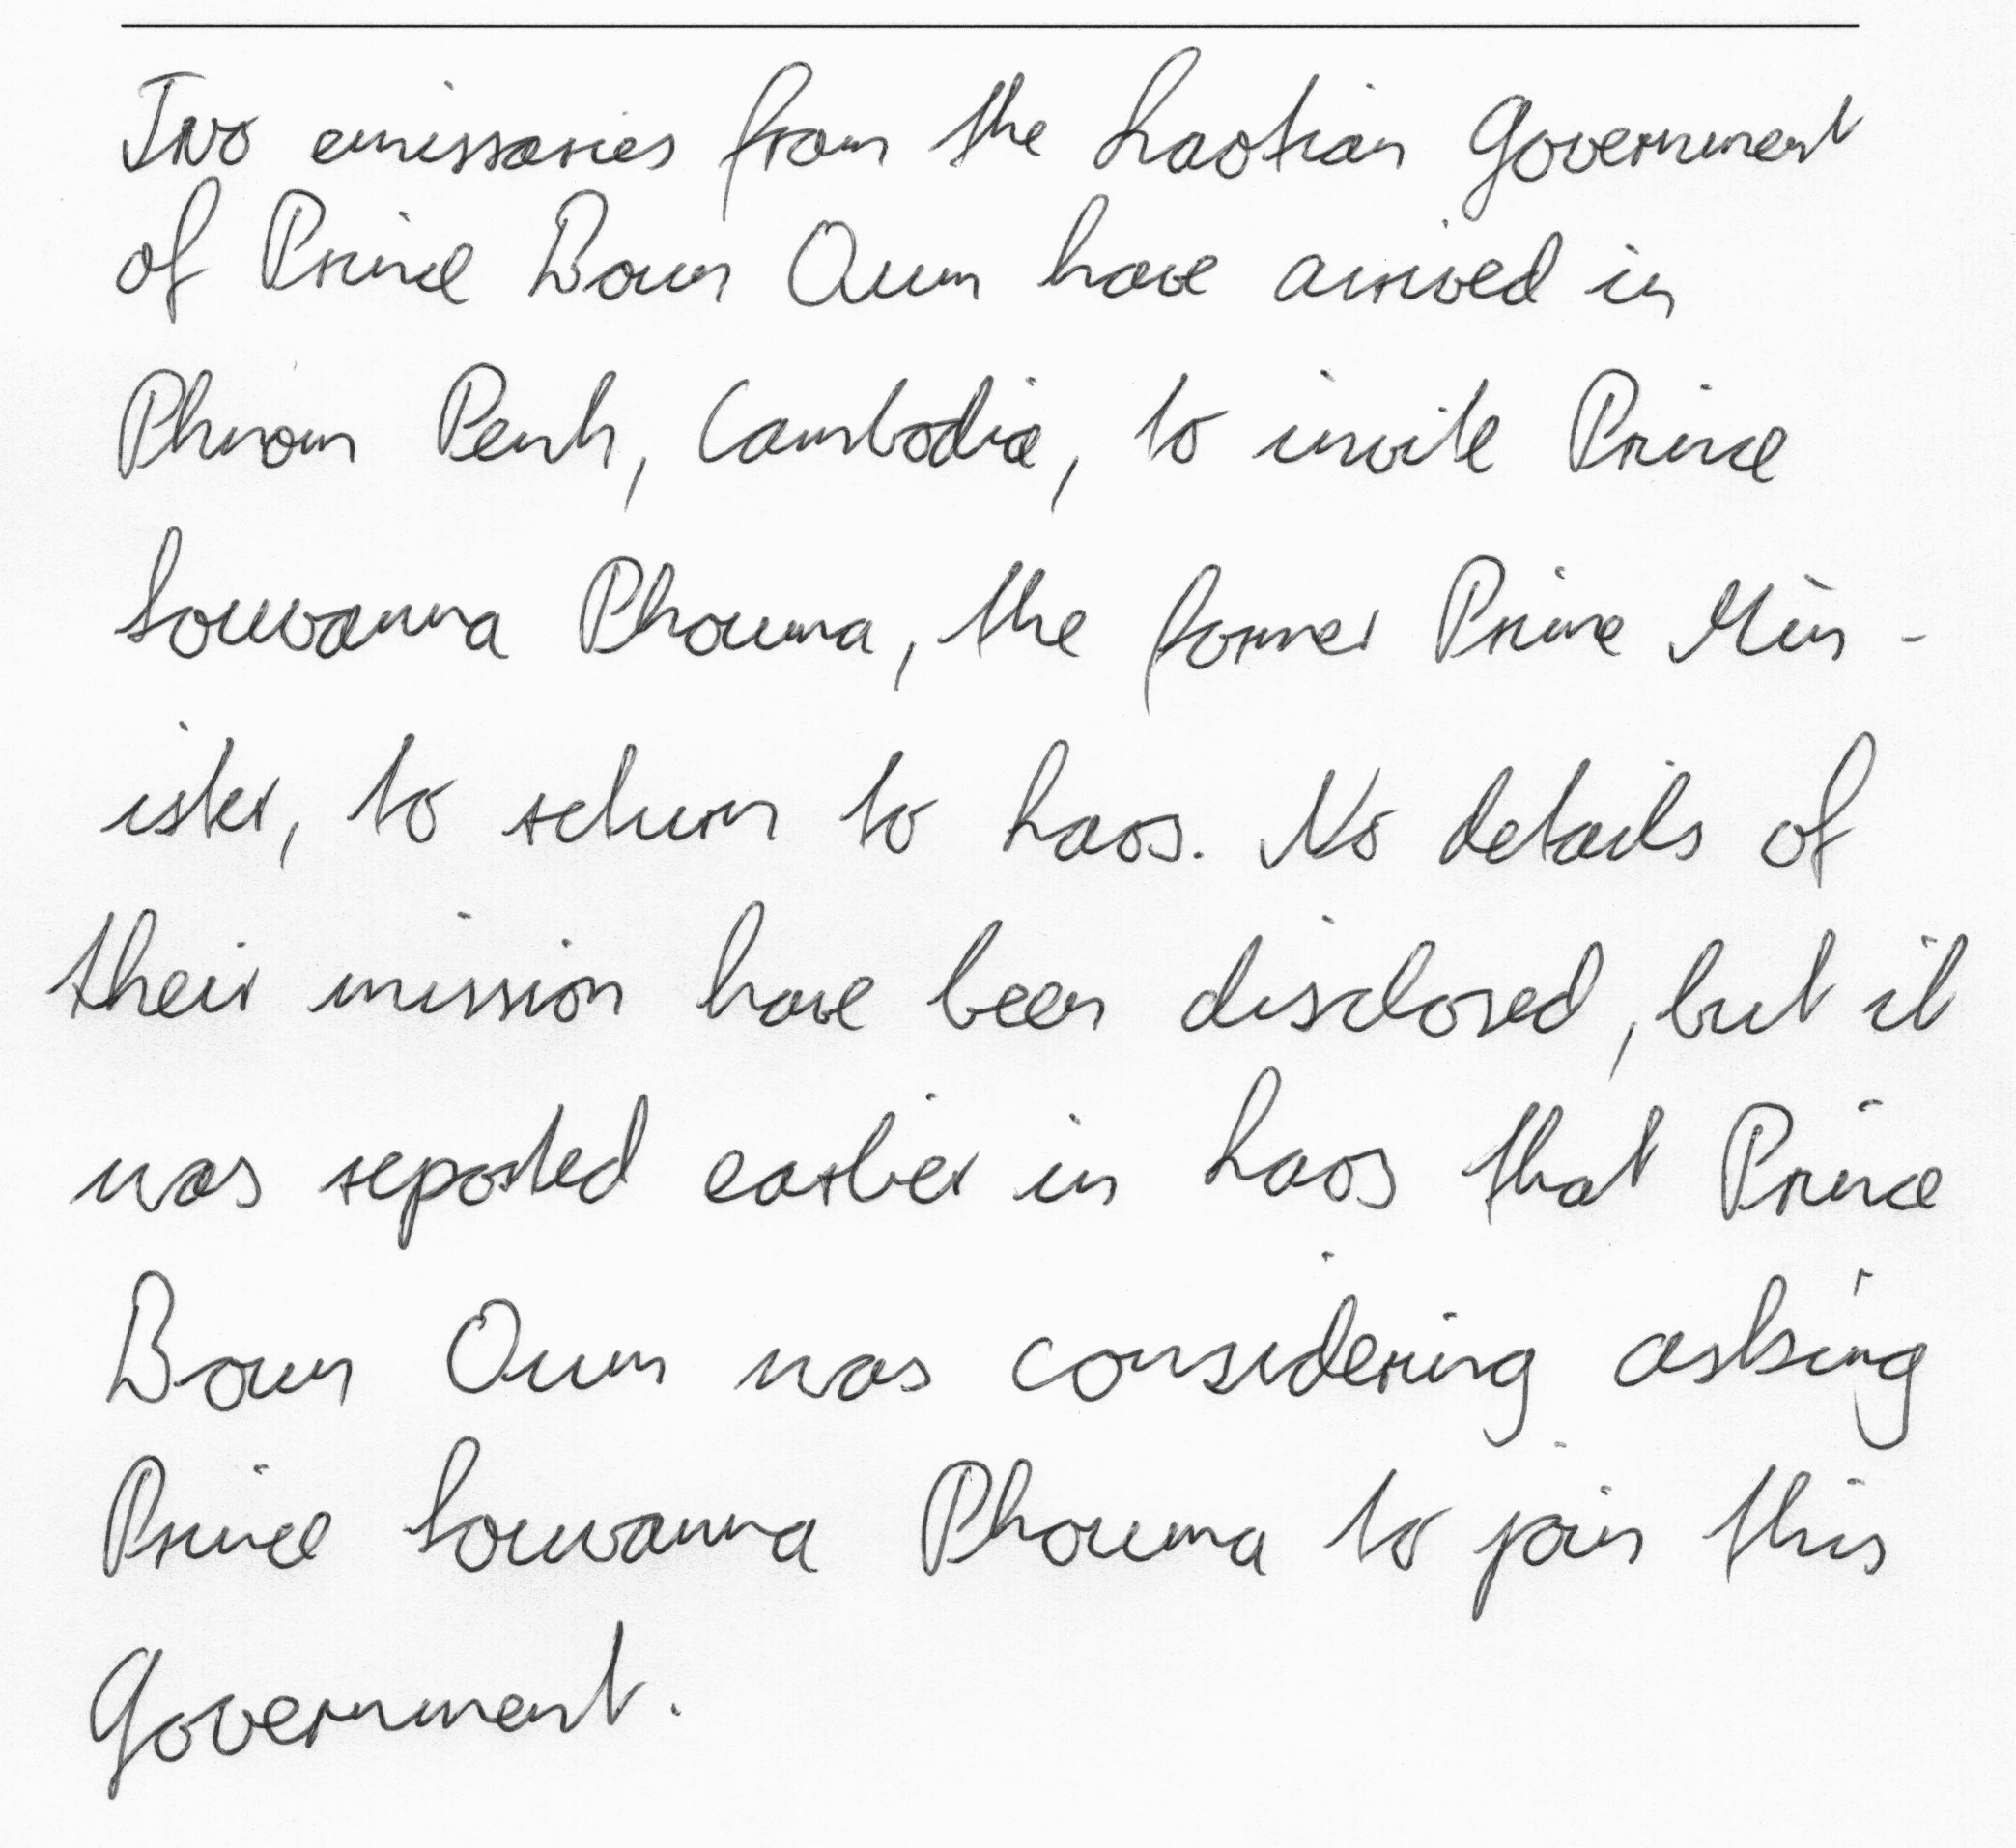

In [57]:
img = open_image(PATH/'test/a03-014.png');
img

In [107]:
res = learn.predict(img)[0]

In [108]:
print(str(res))

Two embraces from the Taxation Government
of Prince Brown have arrived in
Phnom Penh, Canada, to invite Prince
Bavaria Phouma, the former Prime Miss-
sites, to return to Laos. No details of
their mission have been disclosed, but it
was reported earlier in has that Prince
Brown Owen was considering asking
Prince Souvanna Phouma to join this
Government.


In [188]:
print(str(res))

Two embraces from the Taxation Government
of Prince Brown have arrived in
Phnom Penh, Canada, to invite Prince
Bavaria Phouma, the former Prime Miss-
sites, to return to Laos. No details of
their mission have been disclosed, but it
was reported earlier in has that Prince
Brown Owen was considering asking
Prince Souvanna Phouma to join this
Government.
